# Проект: Обучение с учителем: качество модели

Интернет-магазин «В один клик» столкнулся с падением активности покупателей. Поскольку привлечение новых клиентов стало менее эффективным, компания планирует удерживать существующих с помощью персонализированных предложений, основанных на анализе данных и бизнес-моделировании. Ваша задача как стажёра отдела цифровых технологий - разработать решение для персонализации предложений постоянным клиентам с целью повышения их покупательской активности.

## Шаг. Загрузка данных

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
from phik.report import plot_correlation_matrix
from phik import report

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
from google.colab import files

# Загружаем сразу несколько файлов (можно выделить их при выборе)
uploaded = files.upload()

Saving money.csv to money (1).csv
Saving market_time.csv to market_time (1).csv
Saving market_money.csv to market_money (1).csv
Saving market_file.csv to market_file (1).csv


In [4]:
df_market_file = pd.read_csv('market_file.csv')
df_market_money = pd.read_csv('market_money.csv')
df_market_time = pd.read_csv('market_time.csv')
df_money = pd.read_csv('money.csv', sep=';', decimal = ',')

In [5]:
display(df_market_file.head())
display(df_market_money.head())
display(df_market_time.head())
display(df_money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## Шаг. Предобработка данных

Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

In [6]:
print(df_market_file.info())
print(df_market_money.info())
print(df_market_time.info())
print(df_money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
dfs = [df_market_file, df_market_money, df_market_time, df_money]
names = ['df_market_file', 'df_market_money', 'df_market_time', 'df_money']

for i, df in enumerate(dfs):
    print(f"Уникальные значения столбцов в {names[i]}:")
    for col in df.select_dtypes(include='object').columns:
        unique_values = df[col].unique()
        print(f"  {col}: {unique_values}")

Уникальные значения столбцов в df_market_file:
  Покупательская активность: ['Снизилась' 'Прежний уровень']
  Тип сервиса: ['премиум' 'стандартт' 'стандарт']
  Разрешить сообщать: ['да' 'нет']
  Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
Уникальные значения столбцов в df_market_money:
  Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Уникальные значения столбцов в df_market_time:
  Период: ['текущий_месяц' 'предыдцщий_месяц']
Уникальные значения столбцов в df_money:


In [8]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')
df_market_time['Период'] = df_market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [9]:
print(df_market_file.duplicated().sum())
print(df_market_money.duplicated().sum())
print(df_market_time.duplicated().sum())
print(df_money.duplicated().sum())

0
0
0
0


Убрали опечатки, дубликатов небыло.

## Шаг. Исследовательский анализ данных

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

In [10]:
for i, df in enumerate(dfs):
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    print(f"Информация по '{names[i]}':")
    display(df.loc[:, num_columns].describe())

Информация по 'df_market_file':


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Информация по 'df_market_money':


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Информация по 'df_market_time':


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Информация по 'df_money':


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Построим графики по признакам.

Сначала количественные.

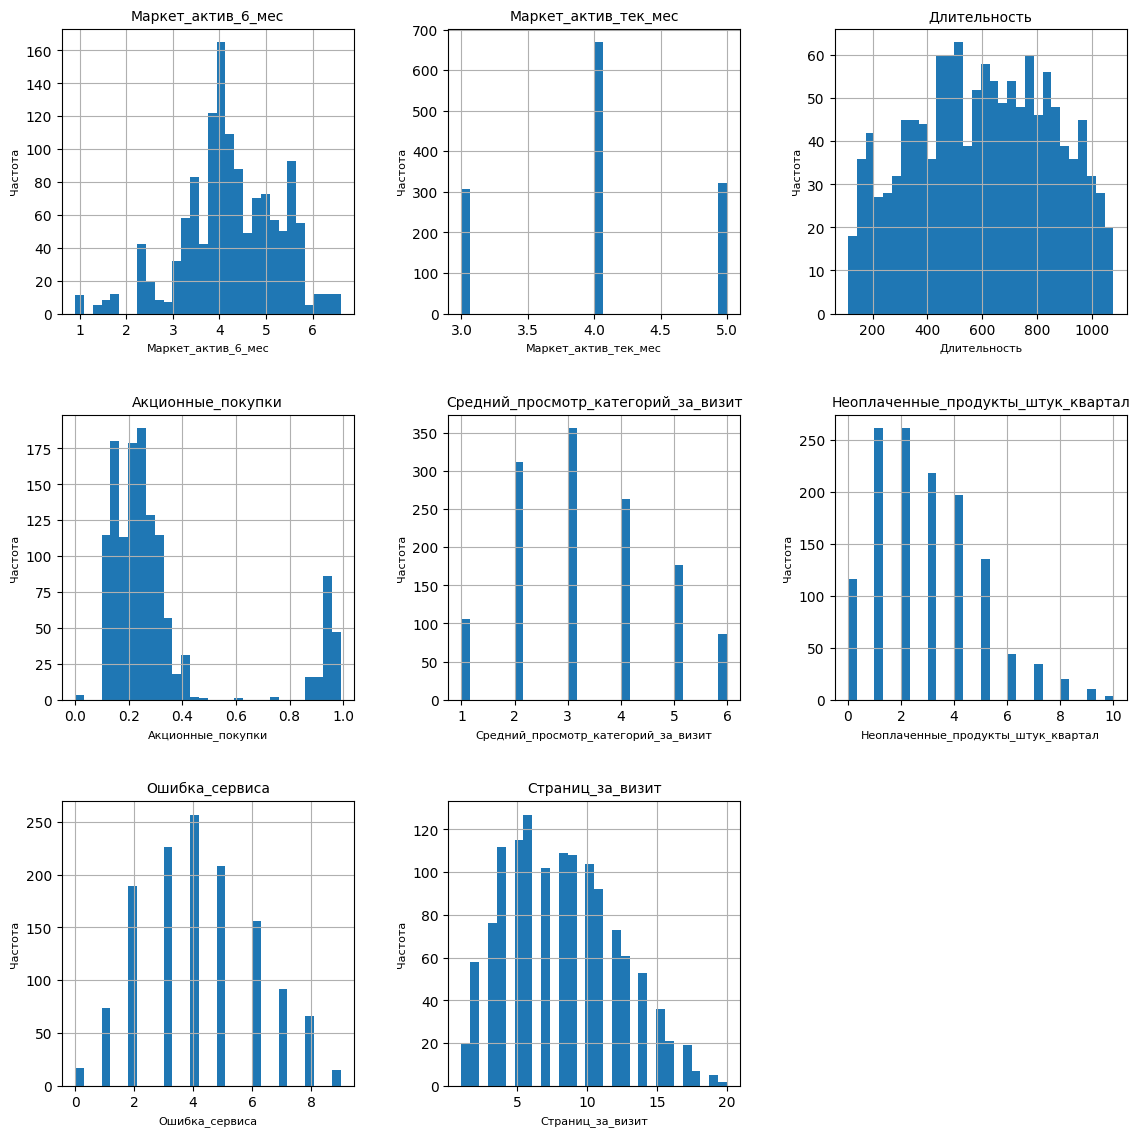

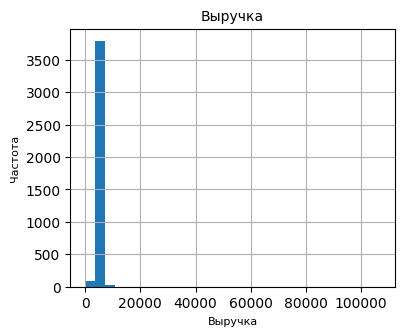

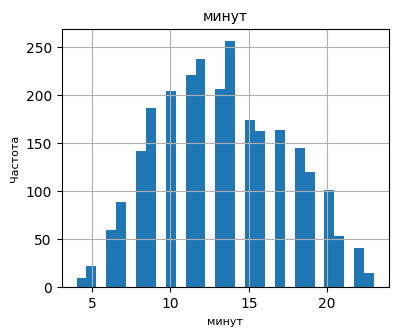

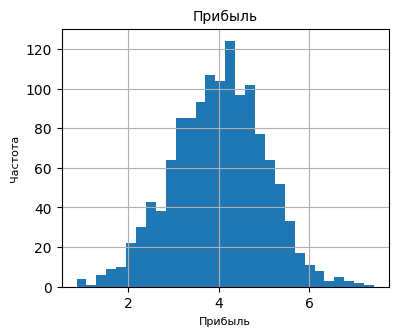

In [11]:
for i, df in enumerate(dfs):
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    if 'id' in num_columns:
        num_columns.remove('id')

    num_cols = len(num_columns)

    if num_cols > 0: #что бы не было ошибок, если численных столбцов нет
        rows = (num_cols // 3) + (num_cols % 3 > 0) #подсчет нужного количества строк
        plt.figure(figsize=(12, 4 * rows )) # регулируем высоту под количество строк

        for i, column in enumerate(num_columns):
            plt.subplot(rows, 3, i + 1)  # количество строк, 3 столбца, текущий график
            df[column].hist(bins=30)
            plt.title(column, fontsize=10)  # Уменьшаем размер шрифта для заголовка
            plt.xlabel(column, fontsize=8)  # Уменьшаем размер шрифта для метки X
            plt.ylabel('Частота', fontsize=8)  # Уменьшаем размер шрифта для метки Y

    plt.tight_layout(pad = 3.0) #увеличиваем отступы
    plt.show()

In [12]:
df_market_file['Маркет_актив_тек_мес'].unique()

array([5, 4, 3])

Графики в основном имеют нормальное распределение. В выручке имеются выбросы, удалим их.

In [13]:
df_market_money = df_market_money.loc[df_market_money['Выручка'] < 10000]

In [14]:
dfs = [df_market_file, df_market_money, df_market_time, df_money]

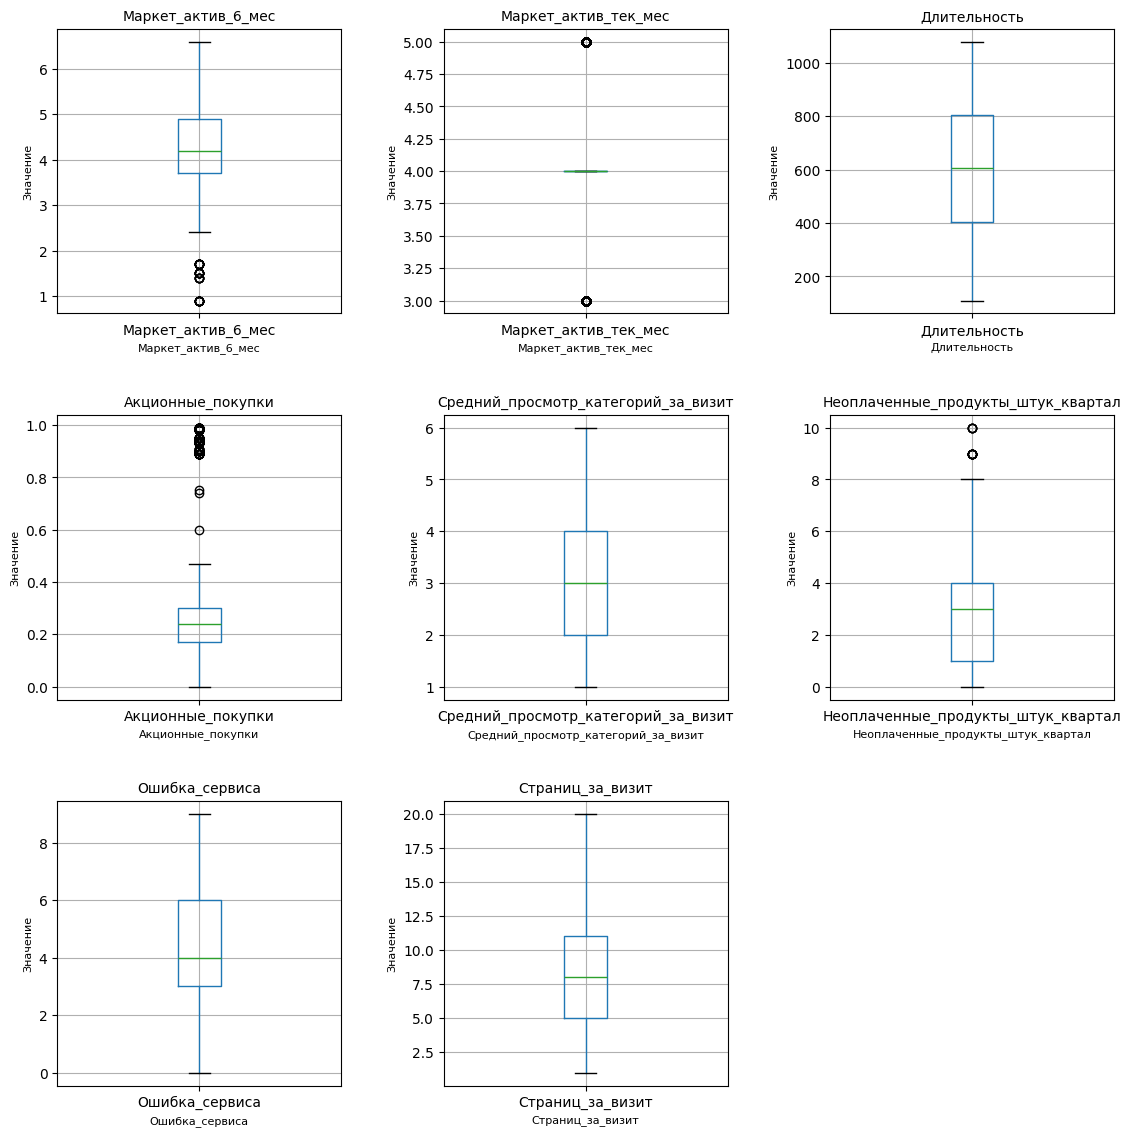

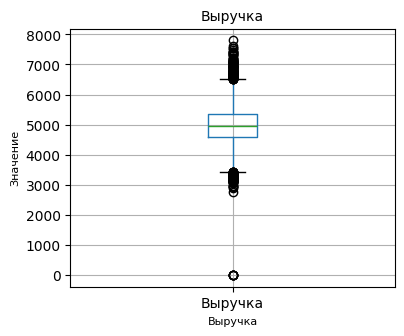

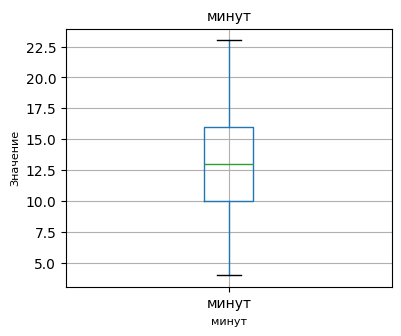

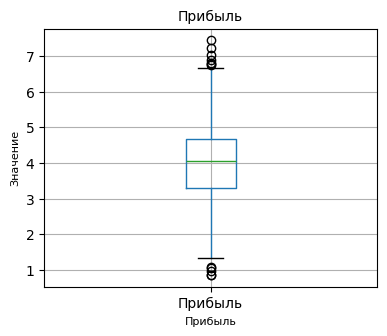

In [15]:
for i, df in enumerate(dfs):
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    if 'id' in num_columns:
        num_columns.remove('id')

    num_cols = len(num_columns)

    if num_cols > 0:
        rows = (num_cols // 3) + (num_cols % 3 > 0) #подсчет нужного количества строк
        plt.figure(figsize=(12, 4 * rows )) # регулируем высоту под количество строк

    for i, column in enumerate(num_columns):
        plt.subplot(rows, 3, i + 1)
        df.boxplot(column=column)
        plt.title(column, fontsize=10)
        plt.xlabel(column, fontsize=8)
        plt.ylabel('Значение', fontsize=8)

    plt.tight_layout(pad = 3.0)
    plt.show()

Теперь построим категориальных признаков.

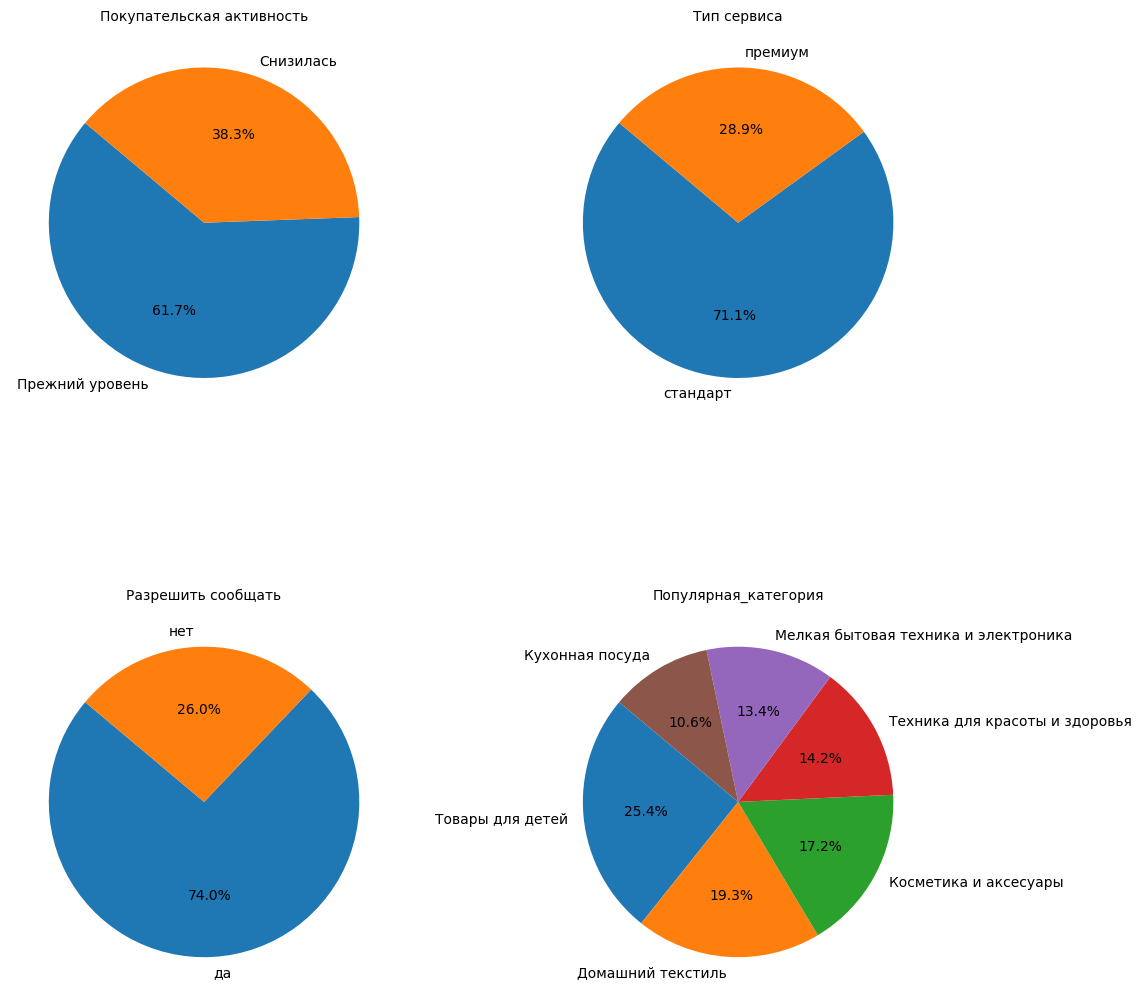

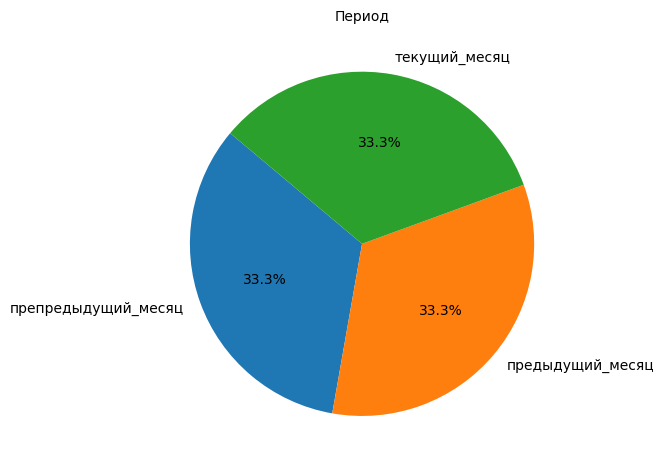

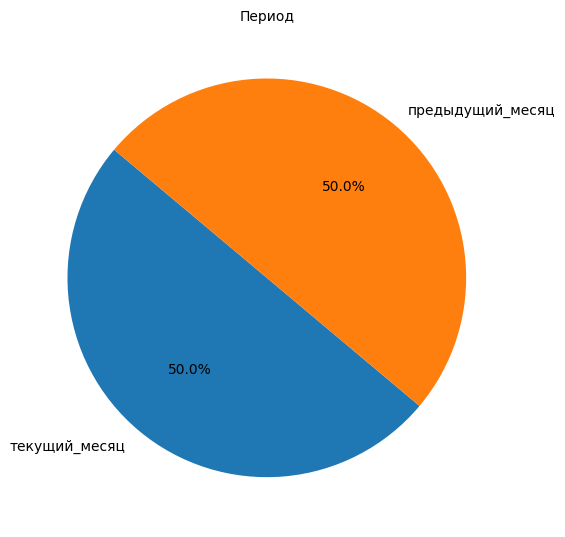

In [16]:
for i, df in enumerate(dfs):
    obj_columns = df.select_dtypes(include=['object']).columns.tolist()

    num_cols = len(obj_columns)

    if num_cols > 0:

        plt.figure(figsize=(12, 12)) #фиксированный размер для всех графиков

        for j, column in enumerate(obj_columns):
            plt.subplot(2, 2, j + 1) #выводим в матрицу 3 на 3

            value_counts = df[column].value_counts()

            plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
            plt.title(column, fontsize=10)

        plt.tight_layout(pad=3.0)
        plt.show()

В первом df признаки распределены не равномерно.

In [17]:
drop = df_market_money[df_market_money['Выручка'] == 0].sort_values(by='id')
drop = drop['id'].tolist()
drop = list(set(drop))
drop

[215348, 215357, 215359]

Провели иследовательский анализ четырех df, вывели графики. На графиках видно, что распределение в основном нрмальное, признаки в первом df распределены не поровну, ближе 1к3. Были удалены выбросы в выручке. С 3-х пользователей нету выручки за препредыдущий и предыдущий месяц, но в текущем есть.

## Шаг. Объединение таблиц

4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся.

4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [18]:
df_m = df_market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='first').reset_index()
df_m.columns.name = None
df_m = df_m.rename(columns={'id': 'id', 'предыдущий_месяц': 'выручка_предыдущий_месяц', 'препредыдущий_месяц': 'выручка_препредыдущий_месяц', 'текущий_месяц': 'выручка_текущий_месяц'})
df_t = df_market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='first').reset_index()
df_t.columns.name = None
df_t = df_t.rename(columns={'id': 'id', 'предыдущий_месяц': 'минуты_предыдущий_месяц', 'текущий_месяц': 'минуты_текущий_месяц'})
df = pd.merge(df_market_file, pd.merge(df_m, df_t, left_index=True, right_index=True), left_index=True, right_index=True).drop(['id_x','id_y'], axis = 1)

In [19]:
df = df[~df['id'].isin(drop)]
#df.set_index('id', inplace=True)
df

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [20]:
df.set_index('id', inplace=True)

## Шаг. Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

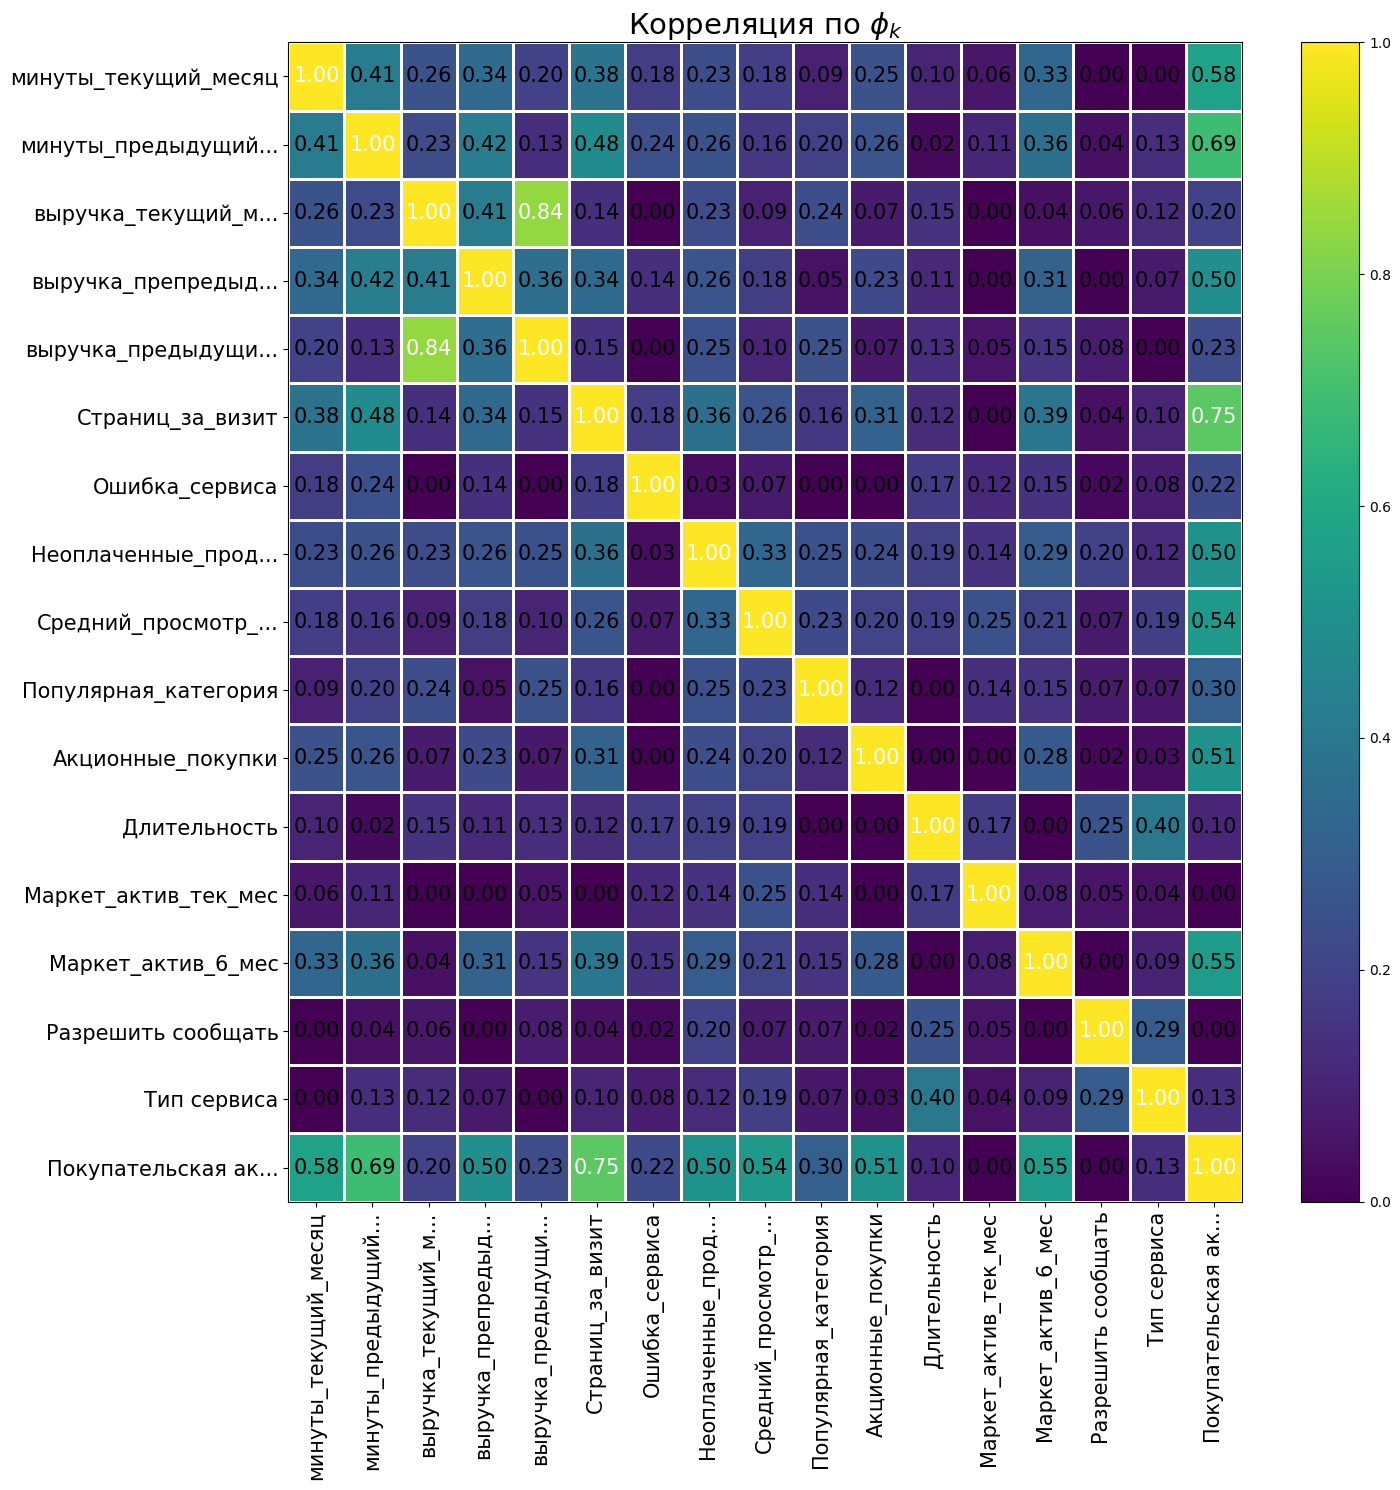

In [21]:
df_corr = df
num_columns = df_corr.select_dtypes(include=['float64','int64']).columns.tolist()
phik_matrix = df_corr.phik_matrix(interval_cols=num_columns)

plot_correlation_matrix(phik_matrix.values,
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,
                       color_map = 'viridis',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5,
                       figsize = (15,15)
                       )
plt.show()

Самая высокая корреляция с прибылью от страниц за визит и минуты.

## Шаг. Использование пайплайнов

Примените все изученные модели. Для этого используйте пайплайны.

6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:

использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.
Выберим метрику ROC AUC. Это мощная и универсальная метрика для оценки моделей классификации, особенно когда классы несбалансированы, важна общая способность к различению классов, и не требуется точная калибровка вероятностей.

In [22]:
df = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Покупательская активность'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность'])

ohe_columns = ['Популярная_категория', 'Разрешить сообщать']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес',
               'Маркет_актив_тек_мес',
               'Длительность',
               'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса', 'Страниц_за_визит',
               'выручка_препредыдущий_месяц',
               'выручка_предыдущий_месяц',
               'выручка_текущий_месяц' ,
               'минуты_предыдущий_месяц',
               'минуты_текущий_месяц']

In [23]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability = True)],
        'models__kernel' : ('linear', 'rbf', 'sigmoid'),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Популярная_категория',
                                                                                'Разрешить '
                                                                                'сообщать']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImpute...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ('linear', 'rbf',
                                                            'sigmoid'),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [24]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [25]:
y_test_pred = randomized_search.predict(X_test)
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
y_test_roc = y_test.map(lambda x: 1 if x == 'Снизилась' else 0).astype('int64')
print(f'Метрика Roc_auc на тестовой выборке: {roc_auc_score(y_test_roc, probabilities_one)}')

Метрика Roc_auc на тестовой выборке: 0.9160296080572747


Лучшая можель - LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')). Метрика ROC_AUC на тренеровочной 0.90, на тестовой 0.91.

## Шаг. Анализ важности признаков

7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.

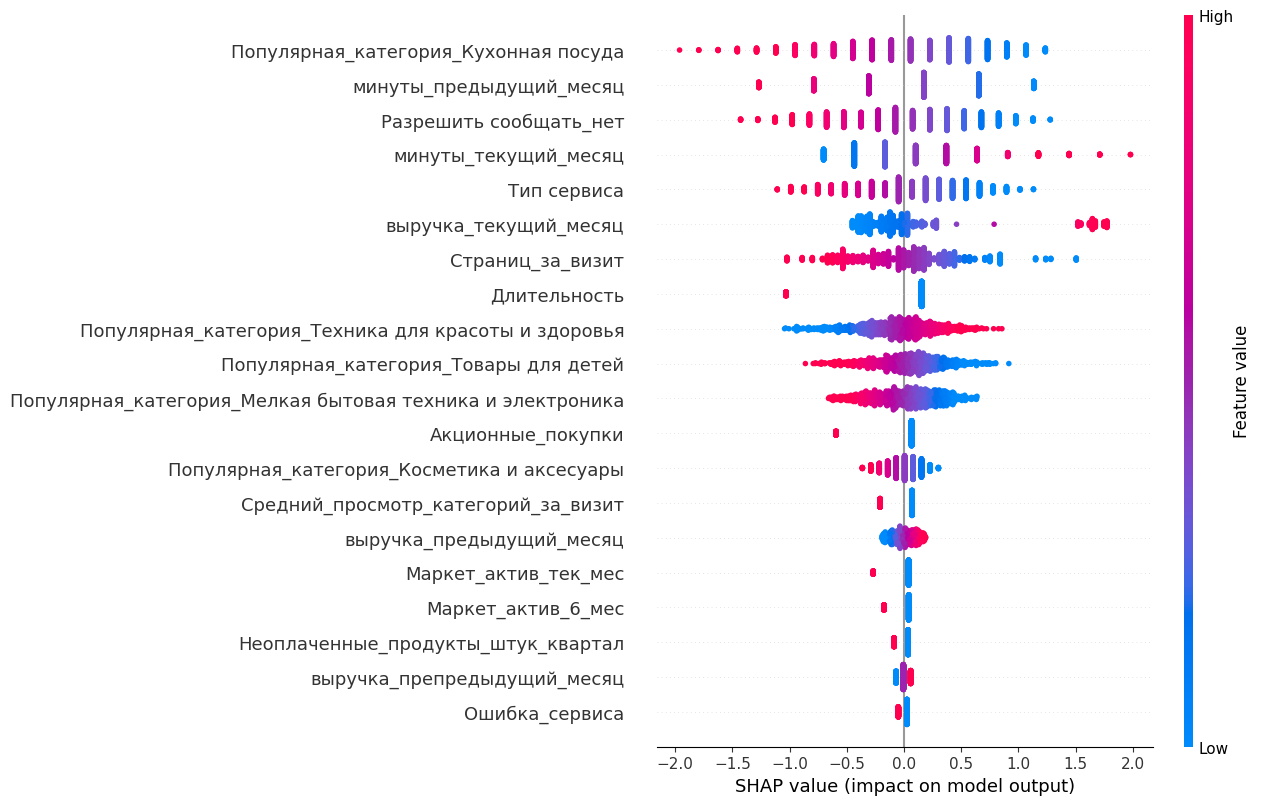

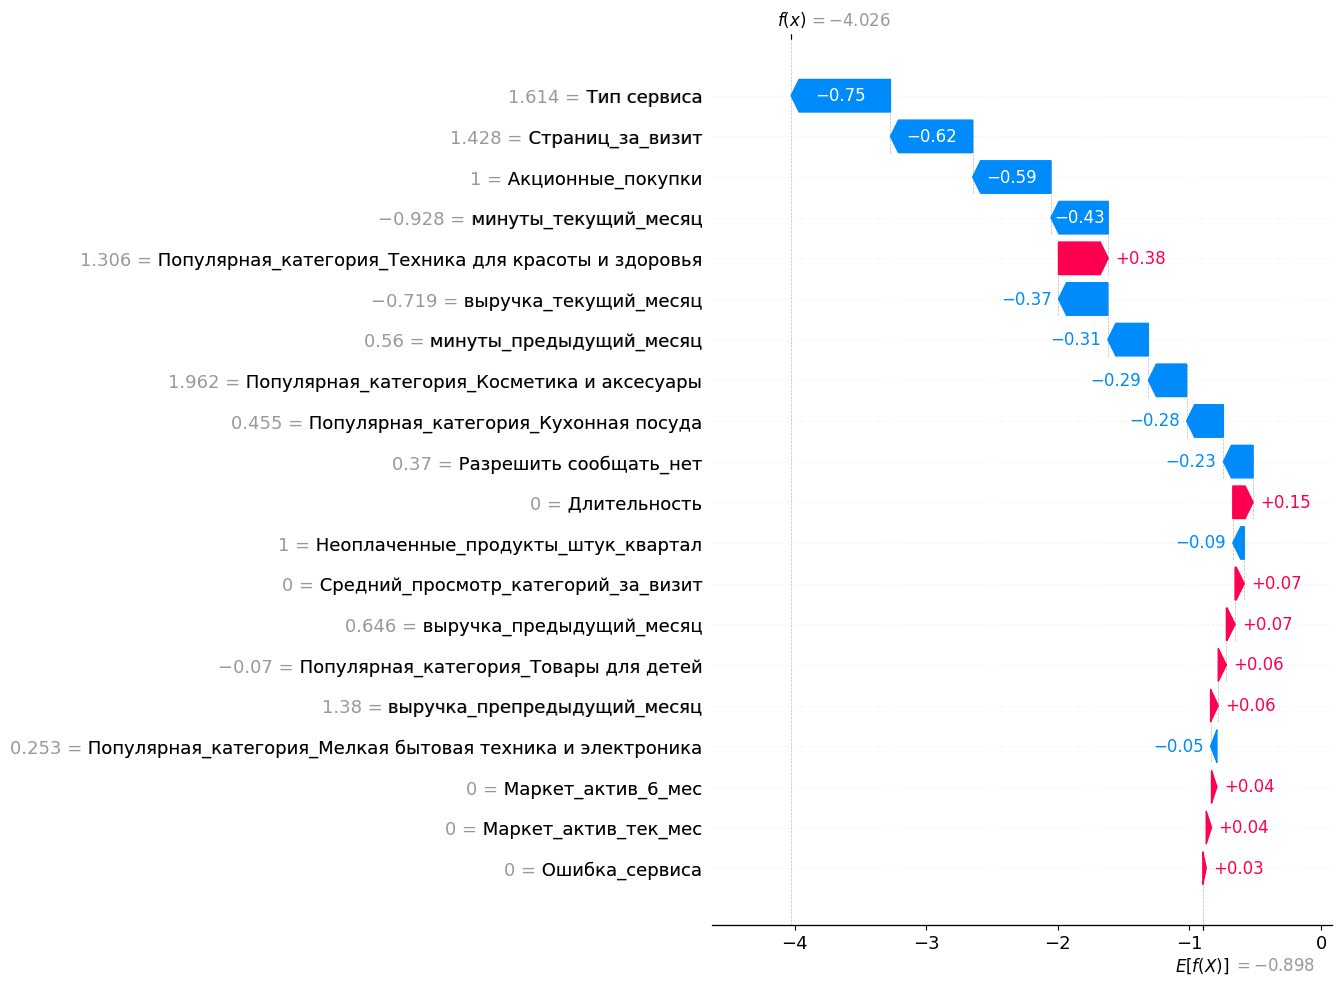

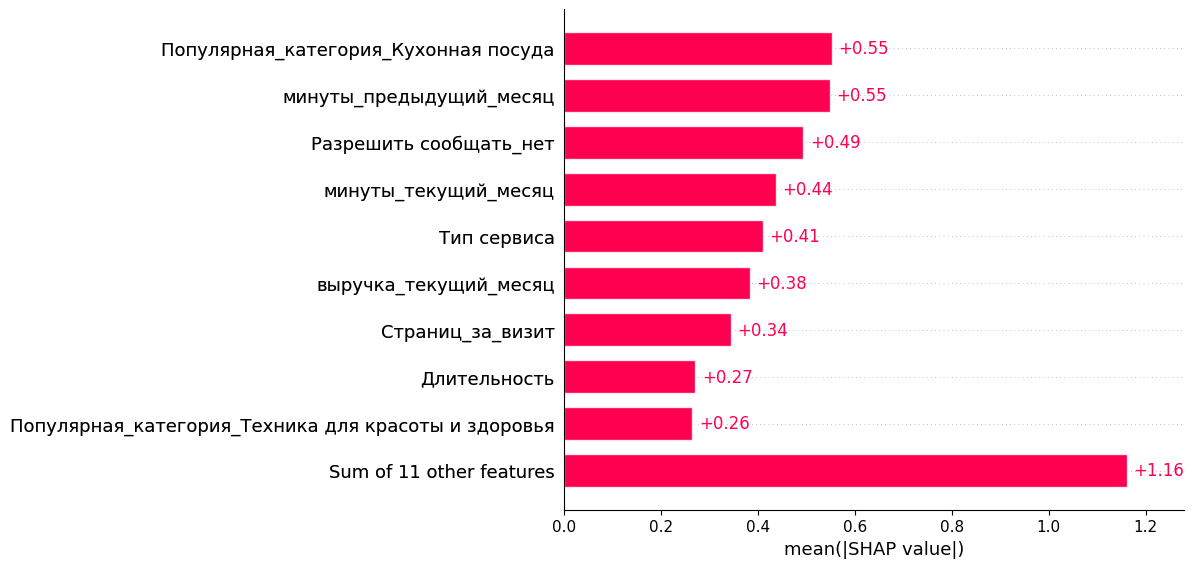

In [26]:
best_model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)

# Получение имен признаков
feature_names = []
feature_names.extend(num_columns)
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(ohe_columns)
feature_names.extend(ohe_feature_names)
feature_names.extend(ord_columns)

explainer = shap.LinearExplainer(best_model, X_train_transformed)
shap_values = explainer(X_train_transformed)
shap_values.feature_names = feature_names

shap.plots.beeswarm(shap_values, max_display = 20)
shap.plots.waterfall(shap_values[5], max_display = 20)
shap.plots.bar(shap_values)

7.2 Сделайте выводы о значимости признаков:

какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

Вывод:
К значимым признакам относятся:

Минуты предыдущий месяц
популярная категория кухонная посуда
разрешить сообщать нет и тип сервиса
К самым малозначимым относятся:
выручка предыдущий месяц
неоплаченные продукты штук квартал
маркет актив 6 мес
Хорошим вариантом будет разместить на главной странице акции Кухонной посуды.

## Шаг. Сегментация покупателей

8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

In [27]:
X_test['Предсказания'] = y_test_pred
X_test['Предсказания'] = X_test['Предсказания'].map(lambda x: 1 if x == 'Снизилась' else 0).astype('int64')

X_test['Вероятности'] = probabilities_one

segment = pd.merge(X_test, df_money, on = 'id', how = 'left')

In [28]:
segment['Прибыль'].mean()

np.float64(3.907438271604938)

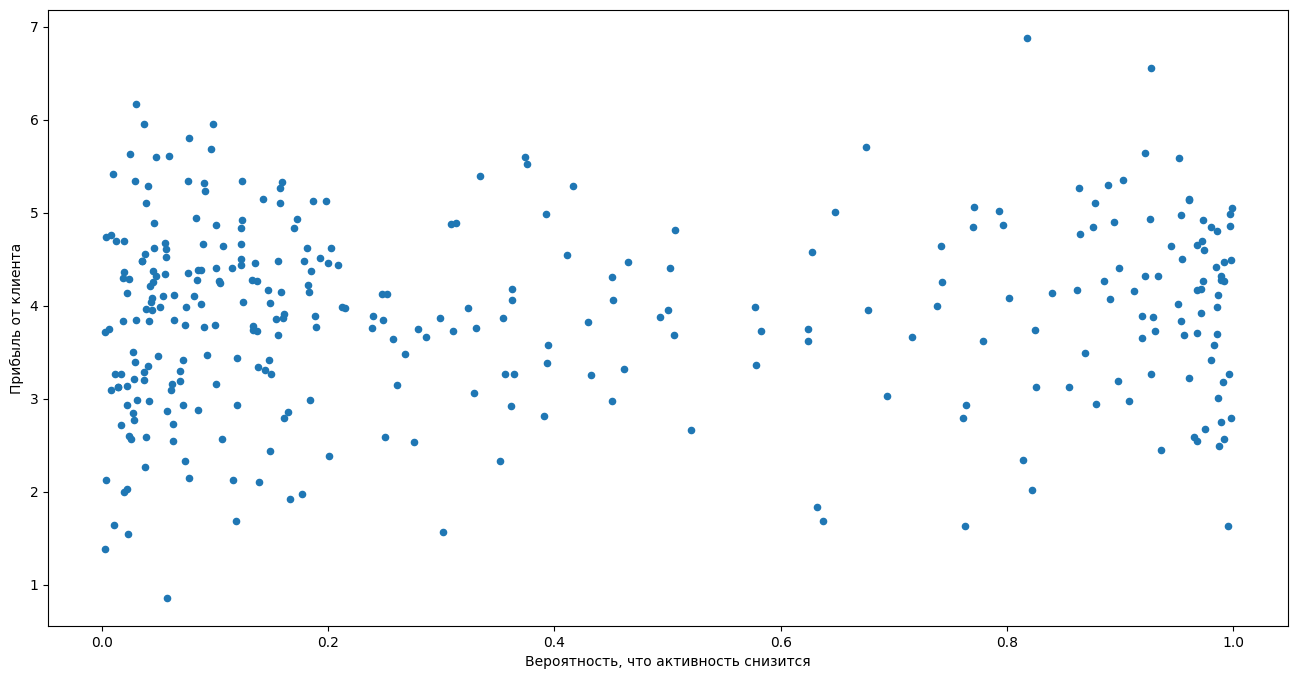

In [29]:
segment.plot.scatter(x = 'Вероятности', y = 'Прибыль', figsize=(16, 8))
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента')
plt.show()

Странно, что у кого снижается активность, совершают покупки в таком же обьеме, как и те, кто имеет прежнюю активность.

8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность:

Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.

Возмем сегмент пользователей которые дают хорошую выручку и имеют шанс снижения активности 0.6.

In [30]:
segment1 = segment[(segment['Прибыль'] > 4) & (segment['Вероятности'] > 0.6)]
print(segment1.columns.tolist())
segment1.head()

['id', 'Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'Предсказания', 'Вероятности', 'Прибыль']


,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,Предсказания,Вероятности,Прибыль
12,215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,1,0.971305,4.18
18,215452,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,4045.0,4963.0,4206.2,11,10,1,0.954897,4.50
21,215484,премиум,нет,2.9,5,448,0.23,Товары для детей,4,2,6,3,5059.0,4267.0,5018.7,5,7,1,0.922078,5.64
38,215496,премиум,да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,2,4,5020.0,4896.0,5237.1,11,11,1,0.944532,4.64
47,215666,стандарт,да,3.5,5,703,0.22,Товары для детей,2,2,8,2,4945.0,4138.0,5150.4,6,10,1,0.950896,4.02


In [31]:
numeric_columns = segment1.select_dtypes(include=['number']).columns

categorical_columns = segment1.select_dtypes(include=['object']).columns

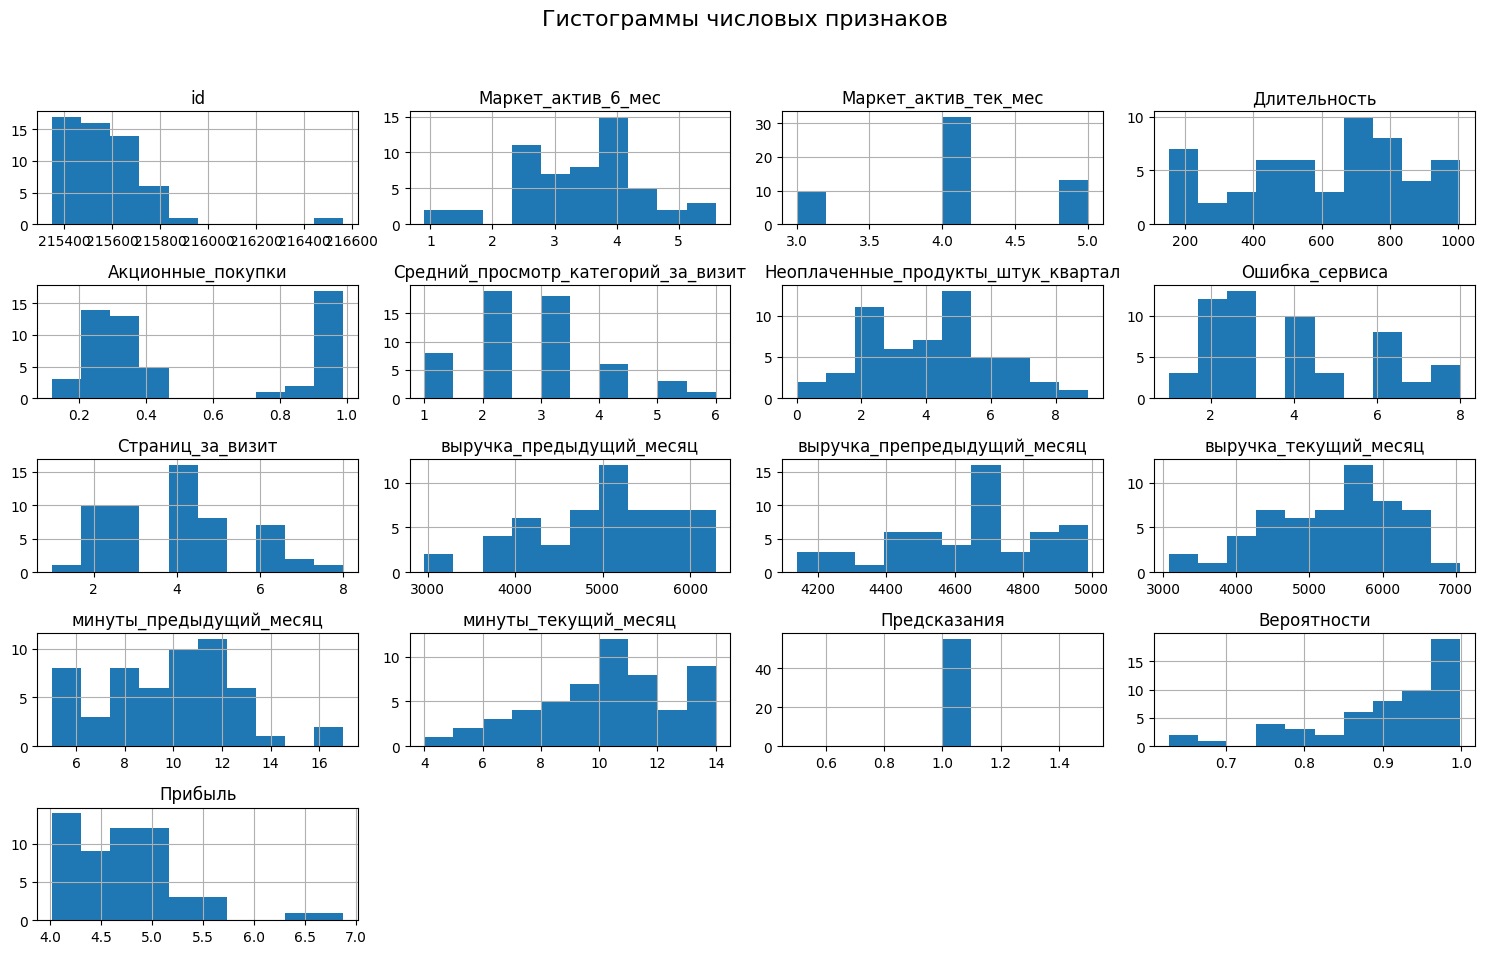

In [32]:
segment1[numeric_columns].hist(figsize=(15, 10))
plt.suptitle('Гистограммы числовых признаков', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

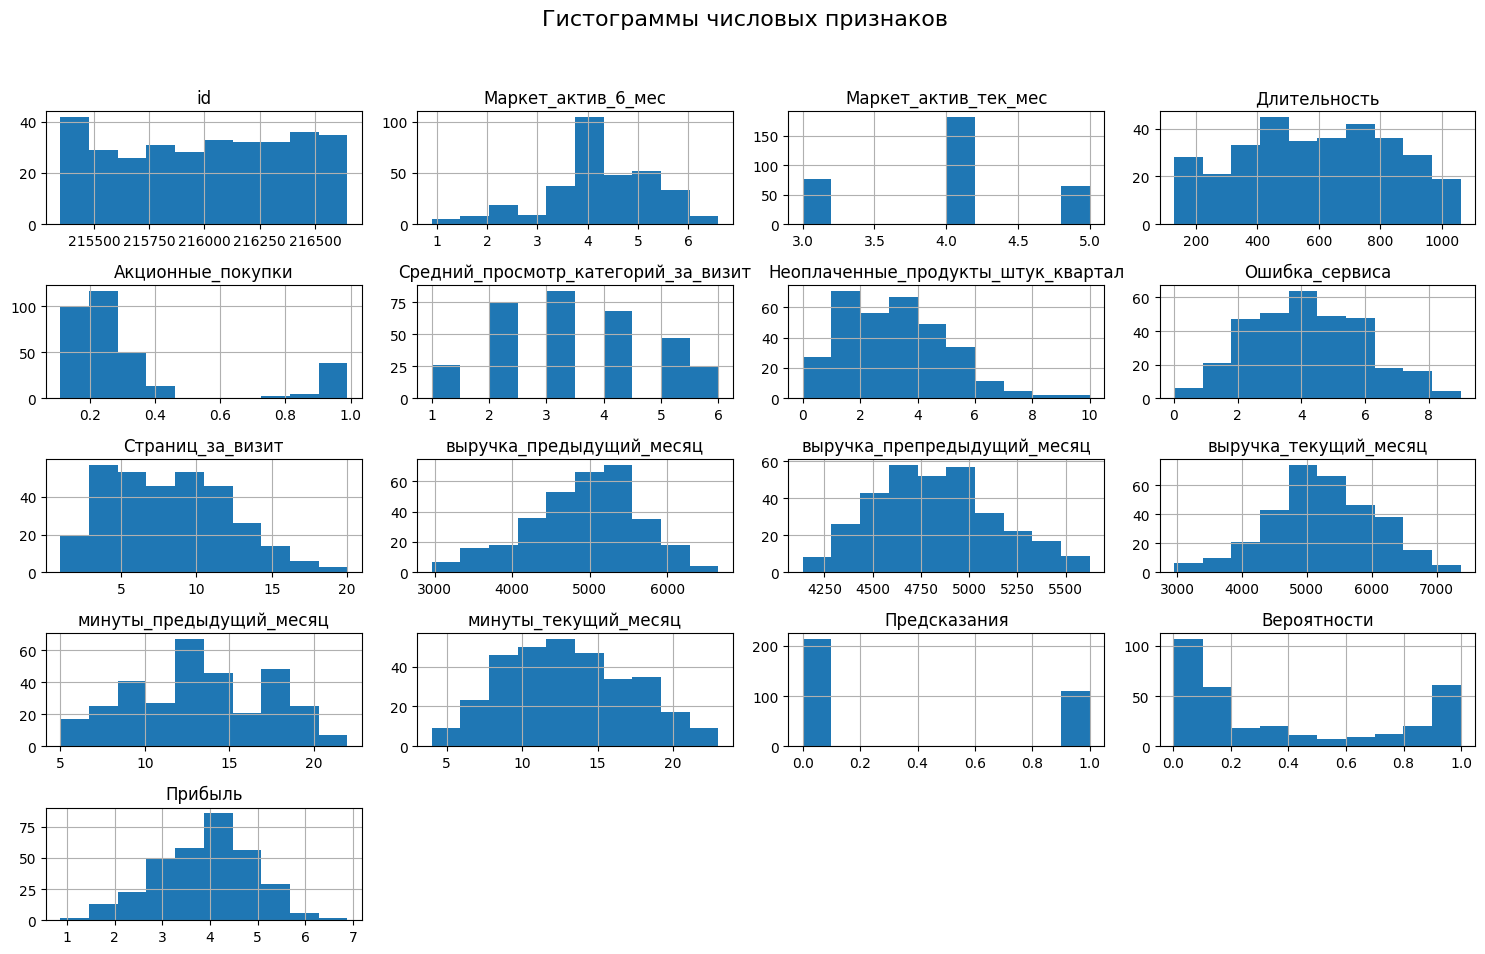

In [33]:
segment[numeric_columns].hist(figsize=(15, 10))
plt.suptitle('Гистограммы числовых признаков', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

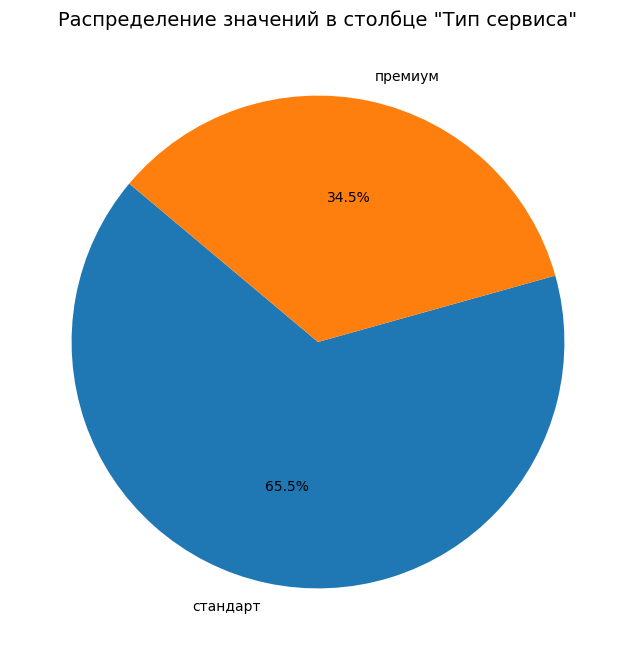

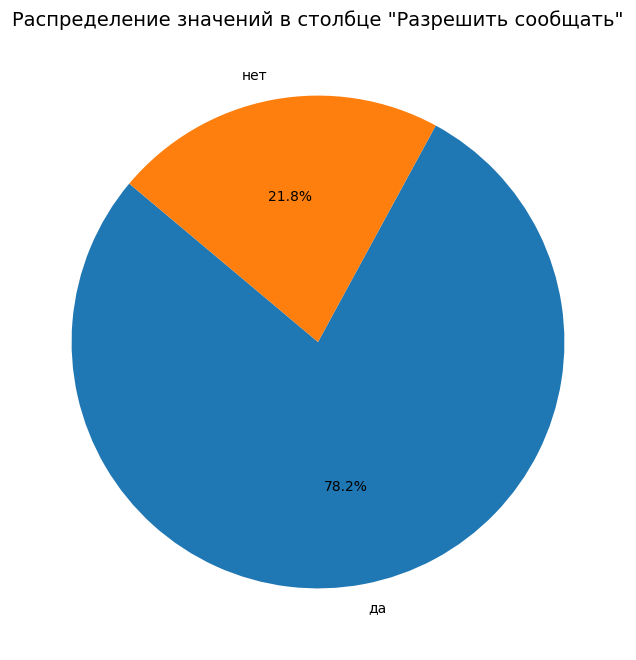

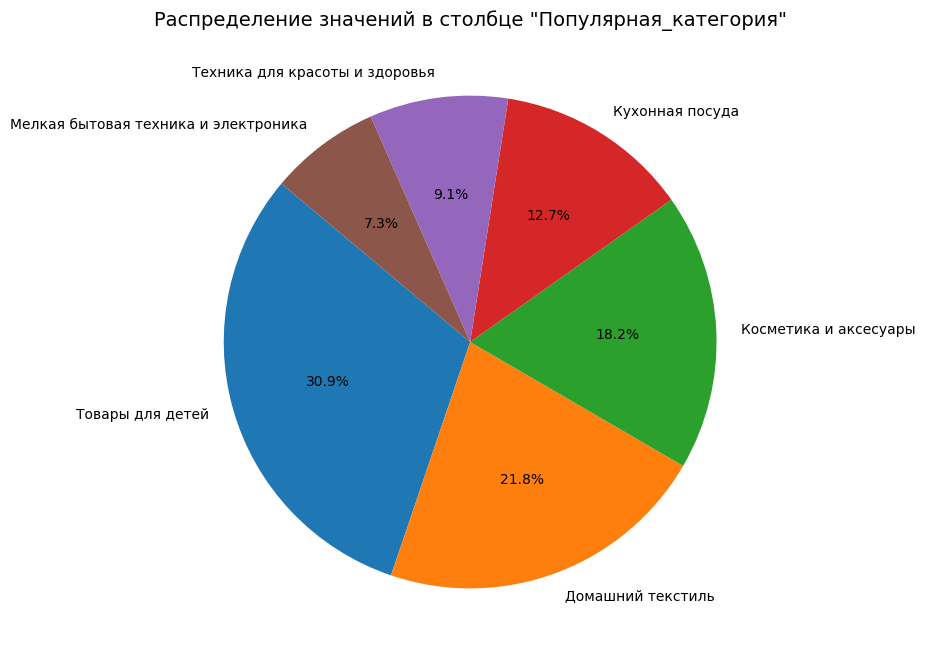

In [34]:
for column in categorical_columns:
    plt.figure(figsize=(8, 8))

    counts = segment1[column].value_counts()

    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)

    plt.title(f'Распределение значений в столбце "{column}"', fontsize=14)
    plt.ylabel(None)
    plt.show()

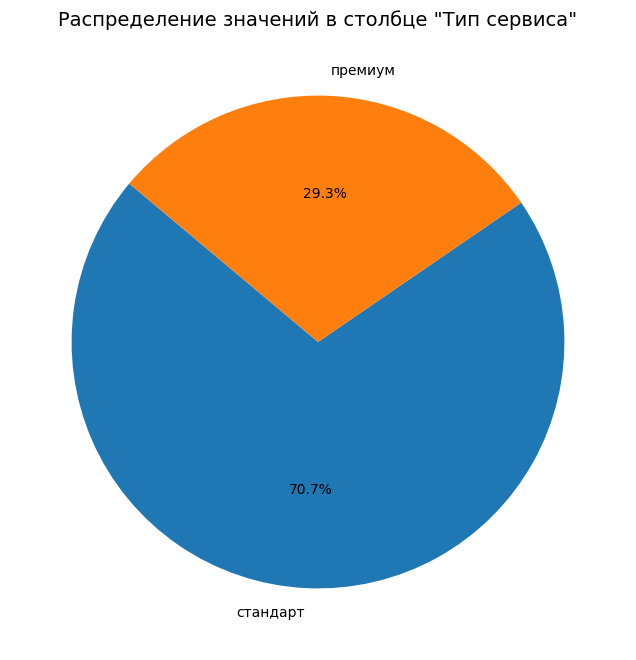

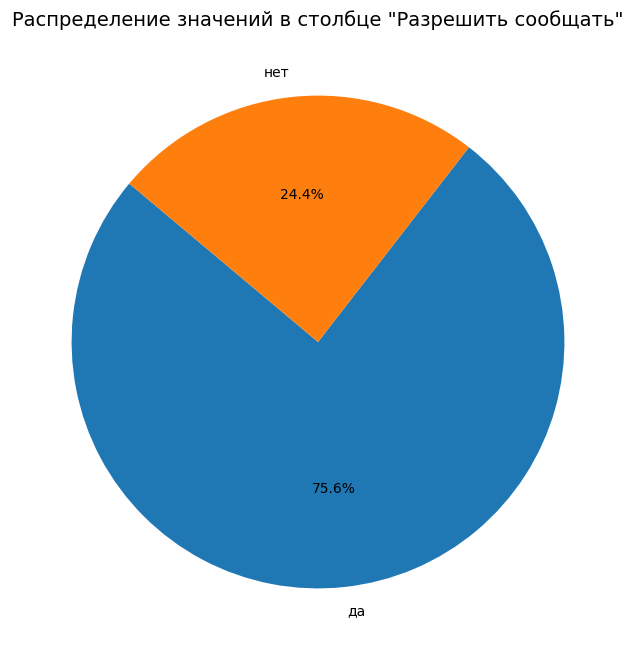

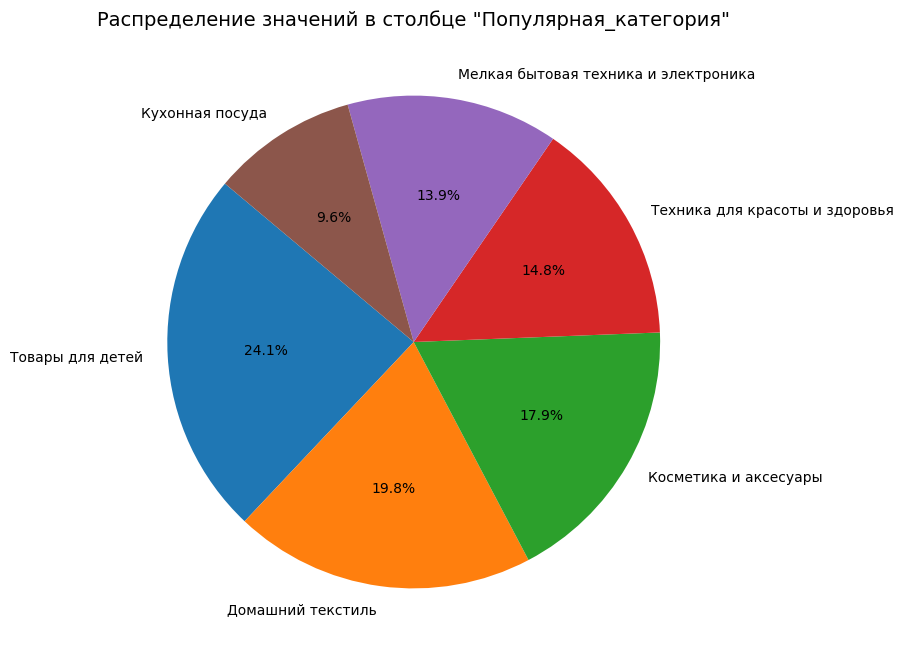

In [35]:
for column in categorical_columns:
    plt.figure(figsize=(8, 8))

    counts = segment[column].value_counts()

    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)

    plt.title(f'Распределение значений в столбце "{column}"', fontsize=14)
    plt.ylabel(None)
    plt.show()

8.3 Сделайте выводы о сегментах:

какой сегмент вы взяли для дополнительного исследования,
какие предложения вы сделали и почему.

Вывод:
Мы взяли сегмент пользователей, которые приносят хорошую выручку и имеют шанс снижения активности 0.6. В общем графики не сильно поменялись, но категория товары для детей стала занимать больше %.
Предложения:

Попробовать переработать премиум подписку.
Сделать акции в категории товаров для детей.

## Общий вывод

Сделайте общий вывод:

опишите задачу;
опишите исходные данные и проведённую предобработку;
напишите, что вы сделали для поиска лучшей модели;
укажите лучшую модель;
добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

Интернет-магазин «В один клик» столкнулся со снижением покупательской активности и хочет её повысить, удерживая постоянных клиентов с помощью персонализированных предложений. Руководство планирует принимать решения на основе данных и бизнес-моделирования, и вам, как стажёру отдела цифровых технологий, предстоит разработать решение для персонализации предложений.
Данные были обработанны, удалены дубликаты и выбросы.
Для поиска лучшей модели был написан пайплайн, в котором перебирались способы масштабирования данных, модели и гиперпараметры к ним. Лучшая можель - LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')). Метрика ROC_AUC на тренеровочной 0.90, на тестовой 0.91.
К значимым признакам относятся: Минуты предыдущий месяц. популярная категория кухонная посуда. разрешить сообщать нет и тип сервиса.
К самым малозначимым относятся: выручка предыдущий месяц. неоплаченные продукты штук квартал. маркет актив 6 мес.
Предложения бизнесу:

Переработать премиум, неплохой идеей было бы дать пробный премиум тем, у кого снижается активность.
Сделать акции на главной странице для товаров для детей.